# Synthetic Data Generation with GWKokab

In this notebook we'll learn how to leverage GWKokab to generate synthetic data. Let's get started and discover how GWKokab can help us generate fake posteriors of true values.

We are generating data from [`PowerlawPrimaryMassRatio`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/index.html#gwkokab.models.PowerlawPrimaryMassRatio), see eq (B2) and eq (B3) of [Population of Merging Compact Binaries Inferred Using Gravitational Waves through GWTC-3](https://link.aps.org/doi/10.1103/PhysRevX.13.011048), for the primary and secondary mass of the binary system, and Truncated Normal distribution for the eccentricity of the orbit. The models are defined as follows:

$$
    p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta} \qquad \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$

## Environment Variables

GWKokab at its core used JAX for fast computation. To setup the behavior of JAX based on the accelerator you are using, you have to set the environment variables. Here are the environment variables that you can set:

In [1]:
!rm -r data # remove old data

In [2]:
import os


env_vars = {
    "JAX_COMPILATION_CACHE_DIR": "jax_cache",
    "JAX_ENABLE_X64": "1",
    "JAX_PLATFORM_NAME": "cpu",
    "NPROC": "16",
    "XLA_FLAGS": "--xla_cpu_multi_thread_eigen=false",
    "XLA_PYTHON_CLIENT_ALLOCATOR": "platform",
}

for var, value in env_vars.items():
    os.environ[var] = value

## Importing libraries

Importing the required libraries for the code. 

In [ ]:
import glob
import random

import numpy as np
import numpyro
from gwkokab.vts import NeuralNetVolumeTimeSensitivity
from jax import numpy as jnp, random as jrd
from jaxtyping import Array, ArrayLike
from matplotlib import pyplot as plt
from numpyro import distributions as dist
from scipy.stats import binom, kstest

from gwkokab.errors import banana_error_m1_m2, truncated_normal_error
from gwkokab.models import PowerlawPrimaryMassRatio
from gwkokab.models.transformations import (
    PrimaryMassAndMassRatioToComponentMassesTransform,
)
from gwkokab.models.utils import JointDistribution, ScaledMixture
from gwkokab.parameters import (
    ECCENTRICITY,
    PRIMARY_MASS_SOURCE,
    SECONDARY_MASS_SOURCE,
)
from gwkokab.poisson_mean import PoissonMean
from kokab.core.population import error_magazine, PopulationFactory

/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0000 00:00:1748619628.526779 2876271 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1748619628.545466 2876271 service.cc:145] XLA service 0x12d4fe180 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748619628.545474 2876271 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1748619628.546774 2876271 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1748619628.546786 2876271 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2025-05-30 11:40:30.263 | DEBUG    | Setting LogLevel to TRACE
2025-05-30 11:40:30.263 | INFO     | ============================================================
2025-05-30 11:40:30.263 | INFO     | GWKokab INFO
2025-05-30 11:40:30.264 | INFO     | ============================================================
2025-05-30 11:40:30.2

In [4]:
numpyro.enable_validation()

By enabling validation of NumPyro distributions in the statement `numpyro.enable_validation()` we can ensure that the values that are outside the support of the distribution return `0.0` probability.

## Parameters

Our model is for Primary Mass $m_1$, Secondary Mass $m_2$, and Eccentricity $\varepsilon$ of the binary system. `parameters` contains their names that are recognized by GWKokab. It is handy to define them in the start and reuse them later in the code

In [5]:
parameters = [
    PRIMARY_MASS_SOURCE.name,
    SECONDARY_MASS_SOURCE.name,
    ECCENTRICITY.name,
]
parameters

['mass_1_source', 'mass_2_source', 'eccentricity']

## Model

Model definition is an integral part of GWKokab. A properly defined model is essential for correct inference. Each model is a probability distribution which is a subclass of [`numpyro.distributions.Distribution`](https://num.pyro.ai/en/stable/distributions.html#distribution).  We can also combine independent distributions to create a more complex model using [`gwkokab.model.utils.JointDistribution`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.JointDistribution). GWKokab is built for the inference of multi source population, which means each source would have its own model as well as their own rate. We have to scale each subpopulation model by its rate and combine them to create the final model. This is a standard approach to build and combine any model in GWKokab and the final model is of type [`gwkokab.models.utils.ScaledMixture`][ScaledMixture].

For this tutorial we have the mass model defined as,

$$
     p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta}
$$

and our eccentricity model is defined as,

$$
    \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$

We will write a `model_builder` function that will take the parameters of the model and return a [`ScaledMixture`][ScaledMixture] object.

[ScaledMixture]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.ScaledMixture

In [6]:
def model_builder(
    log_rate: ArrayLike,
    alpha: ArrayLike,
    beta: ArrayLike,
    mmax: ArrayLike,
    mmin: ArrayLike,
    loc: ArrayLike,
    scale: ArrayLike,
) -> ScaledMixture:
    mass_model = dist.TransformedDistribution(
        PowerlawPrimaryMassRatio(
            alpha=alpha, beta=beta, mmax=mmax, mmin=mmin, validate_args=True
        ),
        PrimaryMassAndMassRatioToComponentMassesTransform(),
        validate_args=True,
    )
    eccentricity_model = dist.TruncatedNormal(
        low=0.0, high=1.0, loc=loc, scale=scale, validate_args=True
    )
    component_distributions = JointDistribution(
        mass_model, eccentricity_model, validate_args=True
    )
    return ScaledMixture(
        log_scales=jnp.array([log_rate]),
        component_distributions=[component_distributions],
        validate_args=True,
    )

[`PowerlawPrimaryMassRatio`][PowerlawPrimaryMassRatio] is defined in for primary mass and mass ratio. As a standard we use primary mass and secondary mass for inference and data generation, therefore the distribution is transformed for primary mass and secondary mass using [`numpyro.distributions.TransformedDistribution`][TransformedDistribution] with appropriate transformation i.e. [`PrimaryMassAndMassRatioToComponentMassesTransform`][PrimaryMassAndMassRatioToComponentMassesTransform] which will convert the primary mass and mass ratio to component masses.

[PowerlawPrimaryMassRatio]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/index.html#gwkokab.models.PowerlawPrimaryMassRatio
[TransformedDistribution]: https://num.pyro.ai/en/stable/distributions.html#transformeddistribution
[PrimaryMassAndMassRatioToComponentMassesTransform]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/transformations/index.html#gwkokab.models.transformations.PrimaryMassAndMassRatioToComponentMassesTransform

In [7]:
true_beta = -3.0
model = model_builder(
    log_rate=5.5,
    alpha=0.0,  # for a uniform m1 distribution
    beta=true_beta,
    mmax=100.0,
    mmin=5.0,
    loc=0.0,
    scale=0.1,
)

## Setup VT

GWKokab estimates the Volume Time Sensitivity (VT) using neural networks. We use [MLPs][MLP] with [ReLU][ReLU] activation to work as piece wise linear estimation of the surface formed by the sensitivity curve. The [MLP][MLP] is trained using the precomputed values of sensitivity. Experimentally we found that the [MLP][MLP] is good at learning $\ln\operatorname{VT}(\omega)$ rather than $\operatorname{VT}(\omega)$, therefore functionally we use the `log` of the VT. We call them Neural VTs. We have trained different Neural VTs and their weights are available at [`gwkokab/asset-store/neural_vts`](https://github.com/gwkokab/asset-store/tree/main/neural_vts).

Downloading weights from asset-store:

[MLP]: https://en.wikipedia.org/wiki/Multilayer_perceptron
[ReLU]: https://en.wikipedia.org/wiki/Relu

In [8]:
!wget -c "https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5"

/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2025-05-30 11:40:30--  https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5 [following]
--2025-05-30 11:40:30--  https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisf

In [9]:
filename = "neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5"


nvt = NeuralNetVolumeTimeSensitivity(
    parameters=parameters,
    filename=filename,
    batch_size=1000,
)
logVT_fn = nvt.get_mapped_logVT()  # mapped logVT function

## Setup Poisson Mean

Poisson Mean is the expectation of VT with respect to the population model. It is estimated using Monte Carlo integration. When the population model can be sampled it is recommended to use the Inverse Transform Sampling method along with the Monte Carlo integration (most accurate of all). And when the population model can not be sampled, we can should use the Importance Sampling method.

The API for the Poisson Mean is designed to be flexible in a way that user can choose the method of integration for each component of the model. We pass `"self"` if we want to use the Inverse Transform Sampling method, otherwise a list of numpyro distributions ordered by the intrinsic parameters of the model.

For more details, see documentation of [`gwkokab.poisson_mean.PoissonMean`][PoissonMean].

[PoissonMean]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/poisson_mean/index.html

In [10]:
erate_estimator = PoissonMean(
    nvt,
    key=jrd.PRNGKey(19),
    num_samples=2_000,
    proposal_dists=["self"],
    time_scale=500.0,
)  # type: ignore[arg-type]

## Generate Data

We have selected the model to generate injections. To simulate injections as events detected by the LVK detectors we add synthetic error in each injections. We can add any type of error in the injections. The API for error to take injection as first argument, size of error as second argument and the [`jax.random.PRNGKey`](https://docs.jax.dev/en/latest/_autosummary/jax.random.PRNGKey.html) as the thirds argument. The function returns an array of values which represents error added into a single injection. This function will be applied to each injection.

In this example we are adding [`banana_error_m1_m2`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/errors/index.html#gwkokab.errors.banana_error_m1_m2) error in component masses and truncated normal error in eccentricity.

In [11]:
error_magazine.register(  # m1 and m2 error
    (parameters[0], parameters[1]),
    lambda x, size, key: banana_error_m1_m2(x, size, key, scale_Mc=1.0, scale_eta=4.0),
)


error_magazine.register(  # eccentricity error
    parameters[2],
    lambda x, size, key: truncated_normal_error(
        x,
        size,
        key,
        scale=0.1,
        low=0.0,
        high=1.0,
        cut_low=0.0,
        cut_high=1.0,
    ),
)

<function __main__.<lambda>(x, size, key)>

Sometimes when an error is added to the injection, it can be outside the physical or mathematical support of the parameter, for example, negative mass. In this case we define a function which will take an array of posterior samples and return a boolean mask of the samples which are outside the support. This function will be applied to each fake posterior sample.

In [12]:
def constraint_fn(x: Array) -> Array:
    """Additional constraints on the generated samples.

    Parameters
    ----------
    x : Array
        array of fake posterior samples

    Returns
    -------
    Array
        boolean array indicating which samples satisfy the constraints
    """
    m1, m2, ecc = jnp.unstack(x, axis=-1)
    # m1, m2 = jnp.unstack(x, axis=-1)
    mask = jnp.logical_and(m1 >= 5.0, m2 >= 5.0)
    mask = jnp.logical_and(mask, m1 >= m2)
    mask = jnp.logical_and(mask, 100.0 >= m1)
    mask = jnp.logical_and(mask, 100.0 >= m2)
    mask = jnp.logical_and(mask, ecc >= 0.0)
    mask = jnp.logical_and(mask, ecc <= 1.0)
    return mask


def constraint_m1_m2(x: Array) -> Array:
    """Additional constraints on the generated samples.

    Parameters
    ----------
    x : Array
        array of fake posterior samples

    Returns
    -------
    Array
        boolean array indicating which samples satisfy the constraints
    """
    m1, m2 = jnp.unstack(x, axis=-1)
    mask = jnp.logical_and(m1 >= 5.0, m2 >= 5.0)
    mask = jnp.logical_and(mask, m1 >= m2)
    mask = jnp.logical_and(mask, 100.0 >= m1)
    mask = jnp.logical_and(mask, 100.0 >= m2)
    return mask

We have defined all the necessary functions and models to generate the data. Now we will pass necessary parameter to the [`PopulationFactory`][PopulationFactory] class which will generate the fake posterior samples. The [`PopulationFactory`][PopulationFactory] class will take care of the rest. It will generate the data, add the error, and save the fake posterior samples.

[PopulationFactory]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/population/index.html#gwkokab.population.PopulationFactory

In [13]:
pop = PopulationFactory(
    model=model,
    parameters=parameters,
    logVT_fn=logVT_fn,
    ERate_fn=erate_estimator.__call__,
    num_realizations=1,
    error_size=5_000,
)


pop.produce()

/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## Checking generated fake posterior samples

File structure of the generated fake posterior samples is as follows:

```txt
data
├── realization_0
│   ├── posteriors
│   │   ├── event_0.dat
│   │   ├── event_1.dat
│   │   ├── event_2.dat
│   │   ...
│   ├── color.dat
│   ├── injections.dat
│   ├── raw_color.dat
│   └── raw_injections.dat
├── realization_1
...
└── realization_N
```

The `posteriors` folder contains the posterior samples of the injections. The `injections.dat` file contains the detected injections generated by the model and `color.dat` contains the integer representing which component of the model the injection belongs to. The `raw_injections.dat` and `raw_color.dat` files contains the raw injections and color values before selection effect. The `event_*.dat` files contains the posterior samples of the injections (error added).

In [14]:
realization_number = 0
DETECTED_INJECTIONS_PATH = f"data/realization_{realization_number}/injections.dat"
RAW_INJECTIONS_PATH = f"data/realization_{realization_number}/raw_injections.dat"
POSTERIOR_REGEX = f"data/realization_{realization_number}/posteriors/event_*.dat"

## Loading the Injections and printing their numbers.

In [15]:
data_inj = np.loadtxt(DETECTED_INJECTIONS_PATH, skiprows=1)  # skipping the header
raw_data_inj = np.loadtxt(RAW_INJECTIONS_PATH, skiprows=1)  # skipping the header
print(len(raw_data_inj), len(data_inj))

10112 112


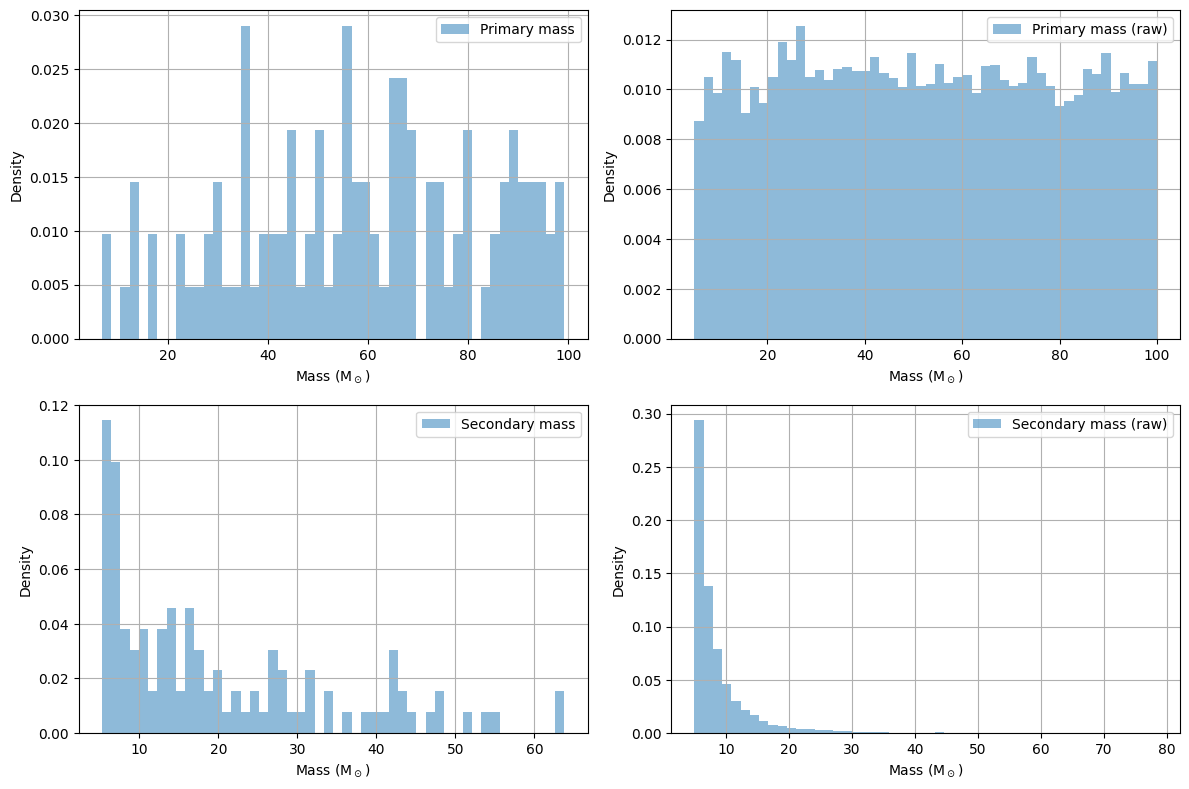

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].hist(
    data_inj[:, 0],
    bins=50,
    density=True,
    alpha=0.5,
    label="Primary mass",
)
ax[0, 1].hist(
    raw_data_inj[:, 0],
    bins=50,
    density=True,
    alpha=0.5,
    label="Primary mass (raw)",
)
ax[1, 0].hist(
    data_inj[:, 1],
    bins=50,
    density=True,
    alpha=0.5,
    label="Secondary mass",
)
ax[1, 1].hist(
    raw_data_inj[:, 1],
    bins=50,
    density=True,
    alpha=0.5,
    label="Secondary mass (raw)",
)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Mass (M$_\odot$)")
        ax[i, j].set_ylabel("Density")
        ax[i, j].legend()
        ax[i, j].grid()
plt.tight_layout()
plt.show()

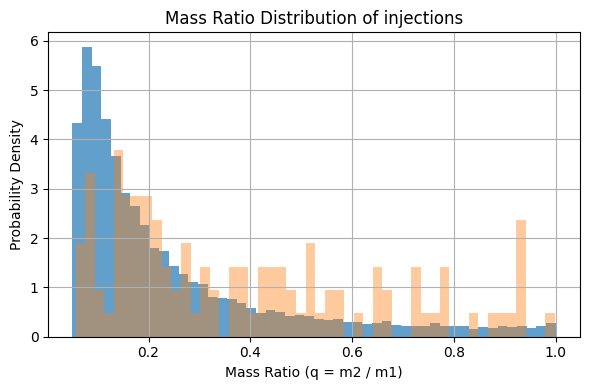

In [17]:
m1_raw = raw_data_inj[:, 0]
m2_raw = raw_data_inj[:, 1]
mass_ratio_raw = m2_raw / m1_raw
m1_sel = data_inj[:, 0]
m2_sel = data_inj[:, 1]
mass_ratio_sel = m2_sel / m1_sel
q_grid = np.linspace(0.01, 1.0, 1000)
p_q_beta2 = q_grid**true_beta  # if alpha = 0.0 then curve exactly matches
p_q_beta2 /= np.trapezoid(p_q_beta2, q_grid)
plt.figure(figsize=(6, 4))
plt.hist(mass_ratio_raw, bins=50, density=True, alpha=0.7, label="Injections (raw)")
plt.hist(
    mass_ratio_sel, bins=50, density=True, alpha=0.4, label="Injections (selected)"
)
# plt.plot(q_grid, p_q_beta2, "r--", label="Injected model (β=0.0)", linewidth=2)
plt.xlabel("Mass Ratio (q = m2 / m1)")
plt.ylabel("Probability Density")
plt.title("Mass Ratio Distribution of injections")
# plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [18]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.size": 12,
        "font.family": "Times New Roman",
    }
)

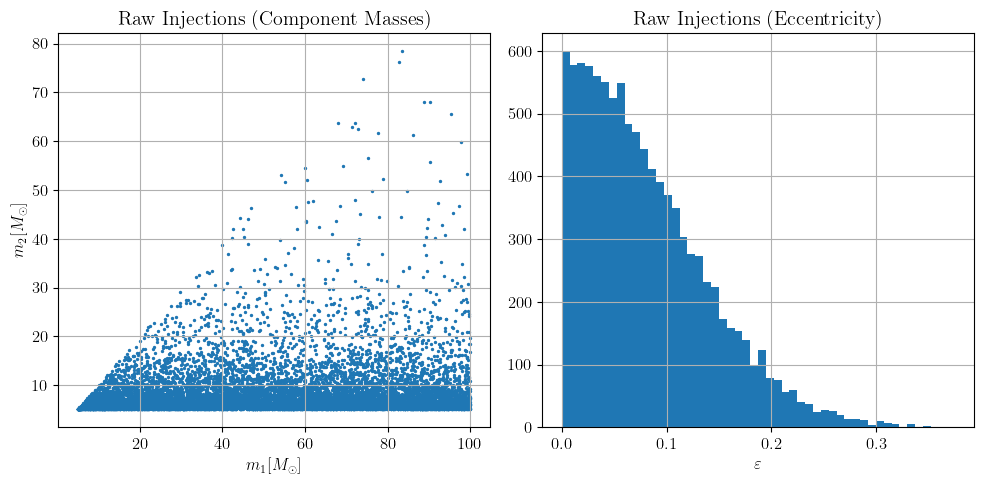

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(raw_data_inj[:, 0], raw_data_inj[:, 1], s=2)
plt.xlabel(r"$m_1 [M_\odot]$")
plt.ylabel(r"$m_2 [M_\odot]$")
plt.title("Raw Injections (Component Masses)")
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(raw_data_inj[:, 2], bins=50)
plt.xlabel(r"$\varepsilon$")
plt.title("Raw Injections (Eccentricity)")
plt.grid()
plt.tight_layout()

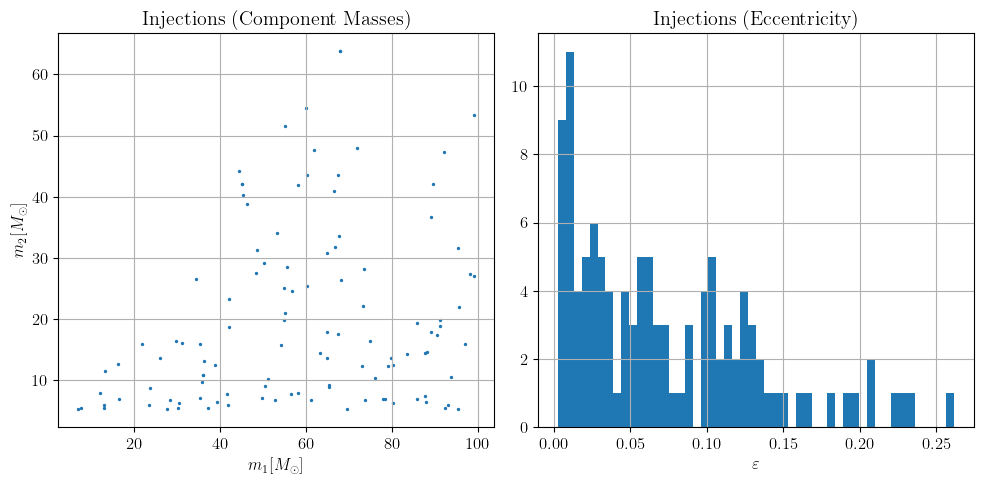

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_inj[:, 0], data_inj[:, 1], s=2)
plt.xlabel(r"$m_1 [M_\odot]$")
plt.ylabel(r"$m_2 [M_\odot]$")
plt.title("Injections (Component Masses)")
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(data_inj[:, 2], bins=50)
plt.xlabel(r"$\varepsilon$")
plt.title("Injections (Eccentricity)")
plt.grid()
plt.tight_layout()

Just to check the true value and shape of the error on a random single event. 
- The true value is missing the banana error in the following plot because we have correlation in $M_c$ and $\eta$ error.
- If you want to see true value in banana shape then remove the correlation in banana error by removing the r0 and r0p [line](https://github.com/gwkokab/gwkokab/blob/5f6709777872595404b090f3dc4c9e85852a624c/src/gwkokab/errors.py#L63) and just use r and rp in the following relation. You will see that true value is always in the banana error, but it's not realistic approach.

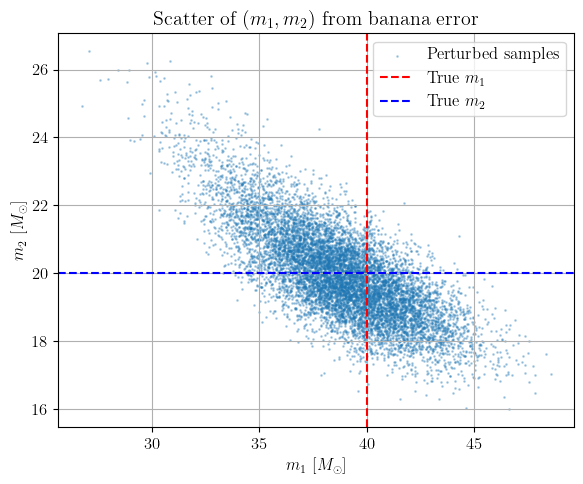

In [21]:
# True values as (m1, m2)
true_val = jnp.array([40.0, 20.0])  # example values to test the behavior
# or Load the raw data
# raw_data_inj = np.loadtxt(RAW_INJECTIONS_PATH, skiprows=1)  # skipping the header
# event_number = 3
# m1 = raw_data_inj[event_number, 0]
# m2 = raw_data_inj[event_number, 1]
# Extract the true values from the raw data
# true_val = jnp.array([m1, m2])
# Generate posterior samples
samples = banana_error_m1_m2(
    x=true_val,
    size=10000,
    key=jrd.PRNGKey(42),
    scale_Mc=1.0,  # thickness of the banana
    scale_eta=4.0,  # length of the banana
)
# samples = samples[constraint_m1_m2(samples)]

# Plotting
plt.figure(figsize=(6, 5))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.3, label="Perturbed samples")
plt.axvline(true_val[0], color="red", linestyle="--", label=r"True $m_1$")
plt.axhline(true_val[1], color="blue", linestyle="--", label=r"True $m_2$")
plt.xlabel(r"$m_1 \ [M_\odot]$")
plt.ylabel(r"$m_2 \ [M_\odot]$")
plt.title("Scatter of $(m_1, m_2)$ from banana error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

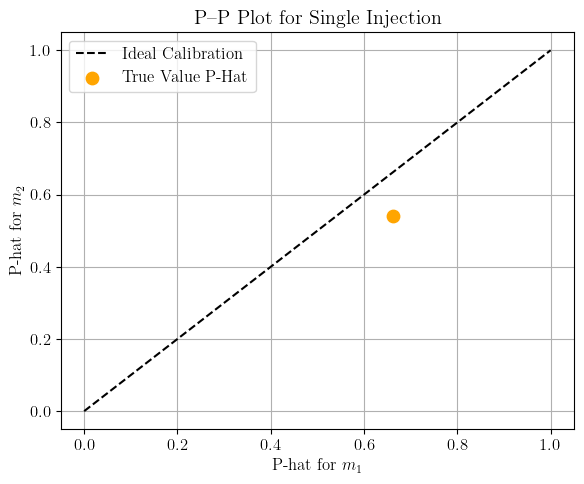

P-hat for m1: 0.6613
P-hat for m2: 0.5407


In [22]:
# Assume samples and true_val are already defined
# samples: shape (N, 2) with columns m1, m2
# true_val: array([m1_true, m2_true])


def compute_phat(posterior_samples, true_value):
    """Fraction of posterior samples less than the true value."""
    return jnp.mean(posterior_samples < true_value)


# Compute p-hat for each parameter
phat_m1 = compute_phat(samples[:, 0], true_val[0])
phat_m2 = compute_phat(samples[:, 1], true_val[1])

# Plot the p-hats on a diagonal reference line
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], "k--", label="Ideal Calibration")

plt.scatter(phat_m1, phat_m2, color="orange", s=80, label="True Value P-Hat")
plt.xlabel(r"P-hat for $m_1$")
plt.ylabel(r"P-hat for $m_2$")
plt.title("P–P Plot for Single Injection")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Also print the values
print(f"P-hat for m1: {float(phat_m1):.4f}")
print(f"P-hat for m2: {float(phat_m2):.4f}")

The above is to check the P hat value of any random event.
- $ P̂ = 0.5$ Posterior is well-centered (ideal).
- $ P̂ << 0.5$ Posterior is biased above true value.
- $ P̂ >> 0.5$ Posterior is biased below the true value.


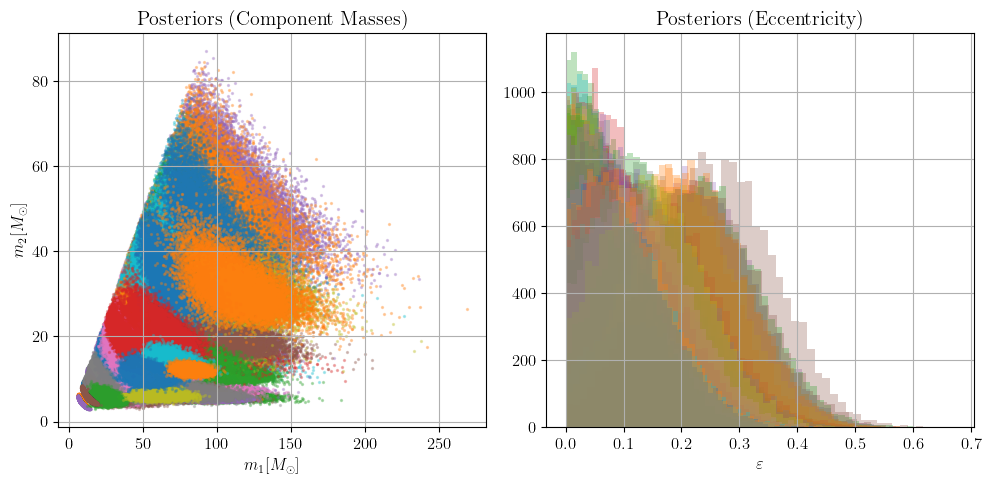

In [23]:
posterior_files = glob.glob(POSTERIOR_REGEX)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

for file in posterior_files:
    data = np.loadtxt(file, skiprows=1)

    try:
        plt.scatter(data[:, 0], data[:, 1], s=2, alpha=0.3)
    except IndexError:
        print(f"File {file} does not have the expected number of columns.")
        continue


plt.xlabel(r"$m_1 [M_\odot$]")
plt.ylabel(r"$m_2 [M_\odot$]")
plt.title("Posteriors (Component Masses)")
plt.grid()


plt.subplot(1, 2, 2)

for file in posterior_files:
    data = np.loadtxt(file, skiprows=1)

    plt.hist(data[:, 2], bins=50, alpha=0.3)
plt.xlabel(r"$\varepsilon$")
plt.title("Posteriors (Eccentricity)")
plt.grid()
plt.tight_layout()

In [24]:
err_fn = error_magazine.registry[tuple(parameters[:2])]
err_fn

<function __main__.<lambda>(x, size, key)>

## PP plots and statistics tests to verify the fake PE.
- Ideal case: KS < 0.10, p > 0.1 : Posterior is very well-calibrated; high statistical match
- Acceptable case: KS < 0.15 , p > 0.05 : Mild deviation from ideal
- Problematic case: KS =>0.15 or KS <=0.05 : Posterior may be miscalibrated, under/overconfident or biased

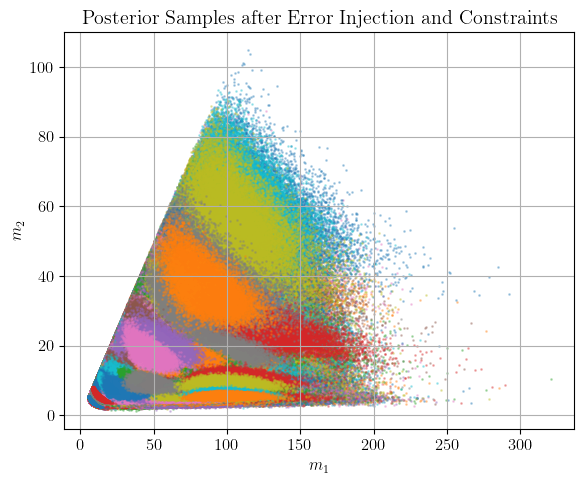

$m_1$ — KS statistic = 0.1406, p-value = 0.0000
$m_2$ — KS statistic = 0.1250, p-value = 0.0000


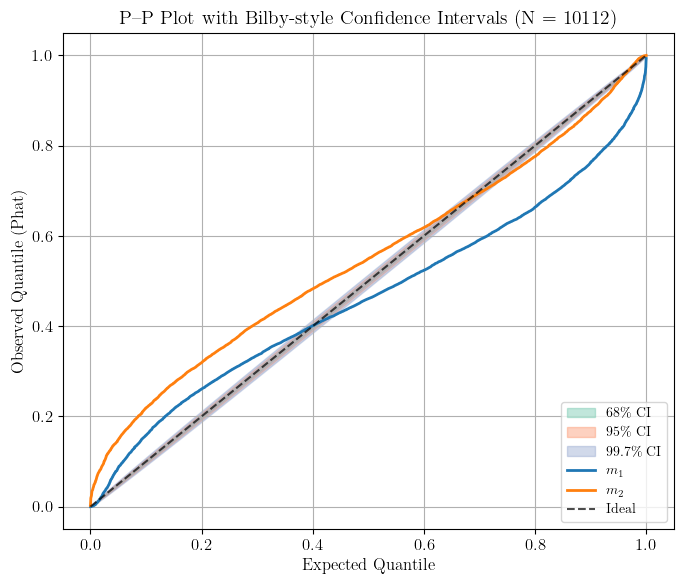

In [25]:
# === Inputs ===
# raw_data_inj: array of injected true values
# error_magazine: registry of error functions
# parameters: list of parameter names, first two are m1 and m2
# constraint_fn: function that filters valid samples

# Setup
err_fn = error_magazine.registry[tuple(parameters[:2])]
randints = [random.randint(0, 1000000) for _ in range(raw_data_inj.shape[0])]


def compute_phat(posterior_samples, true_value):
    posterior_samples = posterior_samples[~np.isnan(posterior_samples)]
    return np.mean(posterior_samples < true_value)


def compute_pp_curve(param_index):
    assert param_index in [0, 1], "Only m1 and m2 are supported in this setup"

    phats = []
    for i, inj in enumerate(raw_data_inj):
        true_val = inj[:2]  # Only m1, m2
        posterior = err_fn(true_val, 50000, jrd.PRNGKey(randints[i]))
        posterior = np.concatenate(
            [posterior, np.full((posterior.shape[0], 1), 0.5)],
            axis=1,  # Add dummy epsilon
        )
        # = posterior[constraint_fn(posterior)]

        if posterior.shape[0] == 0:  # Skip if nothing passes constraint
            continue

        phat = compute_phat(posterior[:, param_index], true_val[param_index])
        phats.append(phat)

    phats = np.sort(phats)
    quantiles = np.linspace(0, 1, len(phats))
    return quantiles, phats


# === Optional Diagnostic Posterior Plot ===
def plot_posterior_scatter():
    plt.figure(figsize=(6, 5))
    for i, inj in enumerate(raw_data_inj):
        true_val = inj[:2]
        posterior = err_fn(true_val, 20000, jrd.PRNGKey(randints[i]))
        posterior = np.concatenate(
            [posterior, np.full((posterior.shape[0], 1), 0.5)], axis=1
        )
        # posterior = posterior[constraint_fn(posterior)]
        if posterior.shape[0] > 0:
            plt.scatter(posterior[:, 0], posterior[:, 1], s=1, alpha=0.3)
    plt.xlabel(r"$m_1$")
    plt.ylabel(r"$m_2$")
    plt.title("Posterior Samples after Error Injection and Constraints")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Uncomment to visualize scatter
plot_posterior_scatter()


# === Compute and Plot Combined P–P Plot ===
labels = [r"$m_1$", r"$m_2$"]
colors = ["tab:blue", "tab:orange"]
stored_xy = []

plt.figure(figsize=(7, 6))
num_events = len(raw_data_inj)
quantiles = np.linspace(0, 1, 1001)

# Define multiple confidence intervals (1σ, 2σ, 3σ)
ci_levels = [0.68, 0.95, 0.997]
ci_colors = ["#66c2a5", "#fc8d62", "#8da0cb"]  # light green, orange, blue
ci_labels = ["68\\% CI", "95\\% CI", "99.7\\% CI"]

for ci, color, label in zip(ci_levels, ci_colors, ci_labels):
    edge = (1 - ci) / 2
    lower = binom.ppf(edge, num_events, quantiles) / num_events
    upper = binom.ppf(1 - edge, num_events, quantiles) / num_events
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(quantiles, lower, upper, alpha=0.4, color=color, label=label)

# Plot each P–P curve
for i, label in enumerate(labels):
    x, y = compute_pp_curve(i)
    stored_xy.append((x, y))
    plt.plot(x, y, label=f"{label}", lw=2, color=colors[i])

    # KS test
    ks_stat, p_val = kstest(y, "uniform")
    print(f"{label} — KS statistic = {ks_stat:.4f}, p-value = {p_val:.4f}")

# Diagonal line
plt.plot([0, 1], [0, 1], "k--", label="Ideal", alpha=0.7)

# Labels and layout
plt.xlabel("Expected Quantile", fontsize=12)
plt.ylabel("Observed Quantile (Phat)", fontsize=12)
plt.title(
    f"P–P Plot with Bilby-style Confidence Intervals (N = {num_events})", fontsize=14
)
plt.legend(fontsize=10, loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

$m_1$ — KS statistic: 0.1814, p-value: 0.0011
$m_2$ — KS statistic: 0.1208, p-value: 0.0700


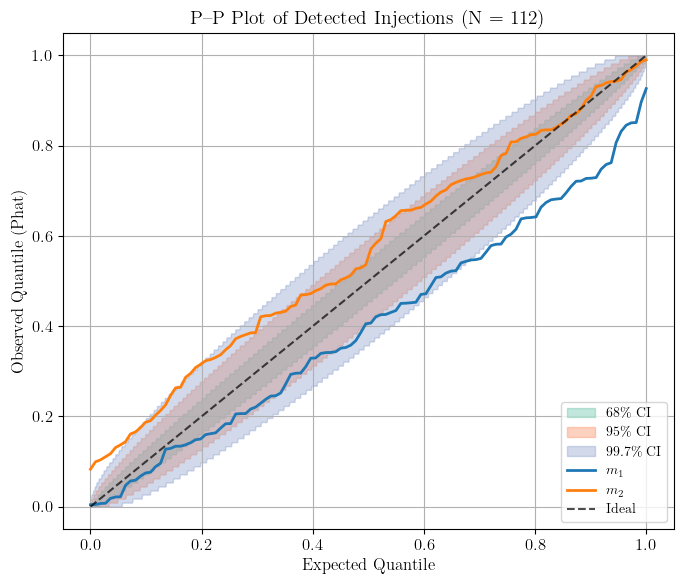

In [26]:
# Load injections
data_inj = np.loadtxt(DETECTED_INJECTIONS_PATH, skiprows=1)

# Get event indices from filenames
indexes = [
    int(pf.strip().split("event_")[1].split(".dat")[0]) for pf in posterior_files
]
data_inj = data_inj[indexes]

# Load posteriors
posteriors = [np.loadtxt(pf, skiprows=1) for pf in posterior_files]


# Define compute_phat
def compute_phat(samples, true_value):
    samples = samples[~np.isnan(samples)]  # remove NaNs
    return np.mean(samples < true_value)


# Compute P–P curve
def compute_pp_curve(param_index):
    phats = []
    for i, inj in enumerate(data_inj):
        true_val = inj[:2]
        posterior = posteriors[i]
        if posterior.ndim != 2 or posterior.shape[1] <= param_index:
            continue
        samples = posterior[:, param_index]
        phat = compute_phat(samples, true_val[param_index])
        phats.append(phat)
    phats = np.sort(phats)
    quantiles = np.linspace(0, 1, len(phats))
    return quantiles, phats


# Plot combined P–P plot
plt.figure(figsize=(7, 6))
labels = [r"$m_1$", r"$m_2$"]
colors = ["tab:blue", "tab:orange"]
num_events = len(data_inj)
quantiles = np.linspace(0, 1, 1001)

# Bilby-style multiple confidence intervals (1σ, 2σ, 3σ)
ci_levels = [0.68, 0.95, 0.997]
ci_colors = ["#66c2a5", "#fc8d62", "#8da0cb"]  # light green, orange, blue
ci_labels = ["68\\% CI", "95\\% CI", "99.7\\% CI"]

for ci, color, label in zip(ci_levels, ci_colors, ci_labels):
    edge = (1 - ci) / 2
    lower = binom.ppf(edge, num_events, quantiles) / num_events
    upper = binom.ppf(1 - edge, num_events, quantiles) / num_events
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(quantiles, lower, upper, alpha=0.4, color=color, label=label)

# Plot P–P curves and compute KS statistics
for i, label in enumerate(labels):
    x, y = compute_pp_curve(i)
    plt.plot(x, y, label=f"{label}", lw=2, color=colors[i])
    ks_stat, p_val = kstest(y, "uniform")
    print(f"{label} — KS statistic: {ks_stat:.4f}, p-value: {p_val:.4f}")

# Ideal diagonal
plt.plot([0, 1], [0, 1], "k--", lw=1.5, alpha=0.7, label="Ideal")

# Layout
plt.xlabel("Expected Quantile", fontsize=12)
plt.ylabel("Observed Quantile (Phat)", fontsize=12)
plt.title(f"P–P Plot of Detected Injections (N = {num_events})", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()

The estimated beta $\hat\beta$ is the solution ($y(\hat\beta)=0$) of the following equation, which has been derived from the maximum likelihood estimation of the powerlaw primary mass ratio model with every parameters fixed except $\beta$:

$$
y({\beta}) = \frac{n}{{\beta}+1} + \sum_{i=1}^{n} \left\{\ln{(m_{2i})-\frac{m_{1i}^{{\beta}+1}\ln(m_{1i})-m_{\text{min}}^{{\beta}+1}\ln(m_{\text{min}})}{m_{1i}^{{\beta}+1}-m_{\text{min}}^{{\beta}+1}}}\right\}
$$

In [27]:
def f(beta, data):
    n = len(data)
    m1 = data[:, 0]
    m2 = data[:, 1]
    y = n / (beta + 1)
    y += np.sum(np.log(m2))
    y -= np.sum(
        (np.power(m1, beta + 1) * np.log(m1) - np.power(5.0, beta + 1) * np.log(5.0))
        / (np.power(m1, beta + 1) - np.power(5.0, beta + 1))
    )
    return y

In [28]:
detected_inj = np.loadtxt(DETECTED_INJECTIONS_PATH, skiprows=1)
raw_inj = np.loadtxt(RAW_INJECTIONS_PATH, skiprows=1)

In [29]:
beta = np.linspace(-10, 10, 1000)
y_raw = np.array([f(b, raw_inj) for b in beta])
y_detected = np.array([f(b, detected_inj) for b in beta])

In [30]:
def search_x_for_y_is_0(array):
    L, R = 0, len(array) - 1
    while L <= R:
        mid = (L + R) >> 1
        if array[mid] >= 0.0:
            L = mid + 1
        else:
            R = mid - 1
    return L

In [31]:
estimated_beta_raw = search_x_for_y_is_0(y_raw)
estimated_beta_detected = search_x_for_y_is_0(y_detected)

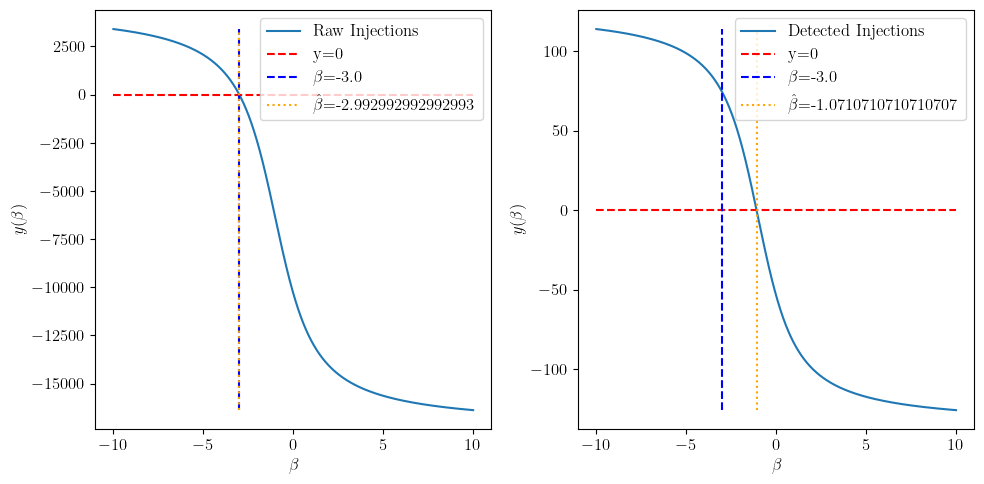

In [32]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(beta, y_raw, label="Raw Injections")

plt.hlines(y=0.0, xmin=beta[0], xmax=beta[-1], linestyles="--", colors="r", label="y=0")
plt.vlines(
    x=true_beta,
    ymin=np.min(y_raw),
    ymax=np.max(y_raw),
    linestyles="--",
    colors="b",
    label=rf"$\beta$={true_beta}",
)
plt.vlines(
    x=beta[estimated_beta_raw],
    ymin=np.min(y_raw),
    ymax=np.max(y_raw),
    linestyles="dotted",
    colors="orange",
    label=rf"$\hat\beta$={beta[estimated_beta_raw]}",
)
plt.legend()
plt.ylabel(r"$y(\beta)$")
plt.xlabel(r"$\beta$")
plt.subplot(1, 2, 2)

plt.plot(beta, y_detected, label="Detected Injections")

plt.hlines(y=0.0, xmin=beta[0], xmax=beta[-1], linestyles="--", colors="r", label="y=0")
plt.vlines(
    x=true_beta,
    ymin=np.min(y_detected),
    ymax=np.max(y_detected),
    linestyles="--",
    colors="b",
    label=rf"$\beta$={true_beta}",
)
plt.vlines(
    x=beta[estimated_beta_detected],
    ymin=np.min(y_detected),
    ymax=np.max(y_detected),
    linestyles="dotted",
    colors="orange",
    label=rf"$\hat\beta$={beta[estimated_beta_detected]}",
)
plt.ylabel(r"$y(\beta)$")
plt.xlabel(r"$\beta$")
plt.legend()

plt.tight_layout()

## Warnings Based on the Observations so far.
- PP Plots or likelihood plots will only work for lower values of beta. usually less than zero.
- The higher the value of beta the more rough plot will show up.
- The error in $M_c$ should be less than 1.0 for reasonable PP plots, because in real observation we have very little error in $M_c$ as compare to $\eta$. So, $\eta$ can have larger error even 10 times the $M_c$.
- If you have corelation in $M_c$ and $\eta$ error, then you may miss the true value within the banana which is normal.
- If the shape of histogram of secondary mass matches in raw injections and detected injections then you may recover the true values and also see nice PP plots. it usually happens in less than 0.0 beta values. (higher beta values have things to resolve).
- $\alpha=0$ should give you uniform primary mass distribution, you may see it in above histograms.
- Error scaling and value of Beta also effects PP plots.
- The following two papers have the recipe of making fake PE.
- The one we followed [implemented](https://doi.org/10.1093/mnras/stw2883) and may be the [improved version](https://arxiv.org/pdf/1809.02063).

If you find any issue or have any question, please feel free to open an issue on [GitHub](https://github.com/gwkokab/gwkokab/issues).